In [1]:

# %%capture
# !git clone https://github.com/arangodb/interactive_tutorials.git
# !rsync -av interactive_tutorials/notebooks/data  interactive_tutorials/notebooks/img  interactive_tutorials/notebooks/tools ./ --exclude=.git
# !pip install python-arango
# !pip install arangopipe==0.0.6.9.5
# !pip install pandas PyYAML==5.1.1 sklearn2
# !pip install jsonpickle
# !pip3 install networkx
# !pip3 install matplotlib
# !pip3 install adbnx-adapter

## Methodology for Analysis

* Find a representation that can provide insights about the problem
* Use the properties of the representation to identify insights about the data
* Fortunately, user online behavior is a well studied problem. We know that a bi-partite graph is a good graph representation for this data
* In this notebook we are interested in summarizing the properties of the frequent shopper group
* We want to apply ideas used in graph and social network analysis to extract summary information about the frequent shopper group.
* The basic ideas for this excercise are drawn from:
    - [Statistical Analysis of Network Data](https://bigdata.unl.edu/documents/ASA_Workshop_Materials/Tutorial%20Statistical%20Analysis%20of%20Network%20Data.pdf): Provides a methodology for characterizing network structure
    
    - [Basic Notions for the Analysis of Affiliate Networks](https://github.com/arangoml/networkx-adapter/blob/master/bipartite_clustering.pdf) : Provides ideas that are useful in analyzing bi-partite graphs.
    
* This notebook will use ideas from both these sources
* [Statistical Analysis of Network Data](https://bigdata.unl.edu/documents/ASA_Workshop_Materials/Tutorial%20Statistical%20Analysis%20of%20Network%20Data.pdf) provides the following perspectives to describe a graph:
    1. Vertex and Edge Characteristics - these capture network structure
    2. Network Cohesion - this tells us how nodes and edges show grouping behavior

* Vertex and edge characteristics can be summarized by:
    1. A set of summary statistics for graph properties
    2. A set of distributional characteristics for graph properties
    3. Centrality
* The degree of a node in the graph captures a purchase - an action of central interest in this work
* We will look at summary and distributional characteristics of node degrees to understand customer shopping preferences in this group.
* Customer node degrees capture items purchased by a customer
* Item node degrees capture customers purchasing an item
* [Basic Notions for the Analysis of Affiliate Networks](https://github.com/arangoml/networkx-adapter/blob/master/bipartite_clustering.pdf) provides some interesting ideas to capture the cohesion characteristics in this graph.
* It discusses the notion of a _projection graph_ in a bipartite graph. It is possible to project one set of nodes into the opposite set by examining the edges incident on the set for which projection is sought.
* User projection graph: Users are connected by an edge if they purchase an item in common.
* Item projection graph: Items are connected by an edge if two or more users purchase it.
* The projection graph directly does not account for the amount of money spent by a user or spent on an item
* An edge simply means common purchase activity - no accounting for amount of purchase.
* To account for the purchase, we may need to resort to other representations or capture it with a computation. Need a better explanation of this. A topic model can accurately account for the spend.
* User projection graph: Captures user purchase diversity and user shopping similarity to other users. It does not capture user spend.
* Item projection graph: Captures item purchase diversity and co-purchasing characteristics. What other items is an item purchased with.
* Centrality measures can be used to identify influential users and items
* [Basic Notions for the Analysis of Affiliate Networks](https://github.com/arangoml/networkx-adapter/blob/master/bipartite_clustering.pdf) introduces bi-partite degree centrality and clustering coefficients.
* Connected components provide a basic notion of cohesion. 
* K-Cores is another perspective of cohesion.


## Connect to Oasis to create the DB for this notebook

In [2]:
login = {"hostname": "arangoml.arangodb.cloud",\
         "username": "MLathah4gprchmhtlbrostz8",\
         "dbName": "MLqugvfcgt448hq4bpqccnw",\
         "password": "ML34q4j114ha31n1j07c3ya9",\
         "port": 8529}

In [3]:
login

{'hostname': 'arangoml.arangodb.cloud',
 'username': 'MLathah4gprchmhtlbrostz8',
 'dbName': 'MLqugvfcgt448hq4bpqccnw',
 'password': 'ML34q4j114ha31n1j07c3ya9',
 'port': 8529}

In [4]:
!chmod -R 755 ./tools/*

In [5]:
# Restore an ArangoDB dump into the database.
!./tools/arangorestore  -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} \
--server.database {login["dbName"]} \
--server.password {login["password"]} \
--replication-factor 3  \
--input-directory "data/retail_freq_cust_data_dump"

2021-06-03T09:21:41Z [119703] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529'
2021-06-03T09:21:45Z [119703] INFO [abeb4] {restore} Database name in source dump is 'MLqugvfcgt448hq4bpqccnw'
2021-06-03T09:21:45Z [119703] INFO [9b414] {restore} # Re-creating document collection 'Customers'...
2021-06-03T09:21:46Z [119703] INFO [9b414] {restore} # Re-creating document collection 'datasets'...
2021-06-03T09:21:47Z [119703] INFO [9b414] {restore} # Re-creating document collection 'deployment'...
2021-06-03T09:21:48Z [119703] INFO [9b414] {restore} # Re-creating document collection 'devperf'...
2021-06-03T09:21:49Z [119703] INFO [9b414] {restore} # Re-creating document collection 'featuresets'...
2021-06-03T09:21:49Z [119703] INFO [9b414] {restore} # Re-creating document collection 'Items'...
2021-06-03T09:21:51Z [119703] INFO [9b414] {restore} # Re-creating document collection 'modelparams'...
2021-06-03T09:21:51Z [119703] INFO [9b414] {restore} # Re-cr

2021-06-03T09:22:12Z [119703] INFO [6ae09] {restore} # Successfully restored edge collection 'run_modelparams'
2021-06-03T09:22:12Z [119703] INFO [94913] {restore} # Loading data into edge collection 'run_models', data size: 261 byte(s)
2021-06-03T09:22:13Z [119703] INFO [6ae09] {restore} # Successfully restored edge collection 'run_models'
2021-06-03T09:22:13Z [119703] INFO [75e65] {restore} # Current restore progress: restored 22 of 23 collection(s), read 741115 byte(s) from datafiles, sent 17 data batch(es) of 52933 byte(s) total size, queued jobs: 0, workers: 2
2021-06-03T09:22:14Z [119703] INFO [6ae09] {restore} # Successfully restored edge collection 'Purchases'
2021-06-03T09:22:14Z [119703] INFO [a66e1] {restore} Processed 23 collection(s) in 34.773962 s, read 741115 byte(s) from datafiles, sent 17 data batch(es) of 741098 byte(s) total size


## Create the Networkx Graph for the Frequent Customer Group with NetworkxAdapter

In [6]:
import networkx as nx
from adbnx_adapter.arangoDB_networkx_adapter import ArangoDB_Networkx_Adapter

# Specify the connection to the ArangoDB Database
con = {'dbName': login["dbName"],
 'username': login["username"],
 'password': login["password"],
 'hostname': login["hostname"],
 'port': login["port"]}

# Create Adapter instance
ma = ArangoDB_Networkx_Adapter(conn = con)

freq_customers = {'vertexCollections': {'Customers': {},
                                         'Items': {}},
                   'edgeCollections': {'Purchases': {'_from', '_to', 'spend'}}}

# Export networkX graph                                  
g = ma.create_networkx_graph(graph_name = '',  graph_attributes = freq_customers)


In [7]:
gp = g.to_undirected()

In [8]:
gp.number_of_edges()

4475

In [9]:
cust_nodes = [n for n in gp.nodes() if n.startswith("Customers")]
item_nodes = [n for n in gp.nodes() if n.startswith("Items")]

In [10]:
len(cust_nodes)

447

In [11]:
len(item_nodes)

75

In [12]:
import networkx as nx
B = nx.Graph()
B.add_nodes_from(cust_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)
B.add_edges_from(list(g.edges()))

In [13]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(B)

True

In [14]:
nx.is_connected(B)

False

In [15]:
degc, degi = bipartite.degrees(B, item_nodes)

In [16]:
dc = [v for k,v in degc]
di = [v for k,v in degi]

In [17]:
import numpy as np
u, c = np.unique(dc, return_counts=True)
u = u[1:]
c = c[1:]
dv = u
fd = [d/sum(c) for d in c]


Text(0.5, 1.0, 'degree vs proportion ')

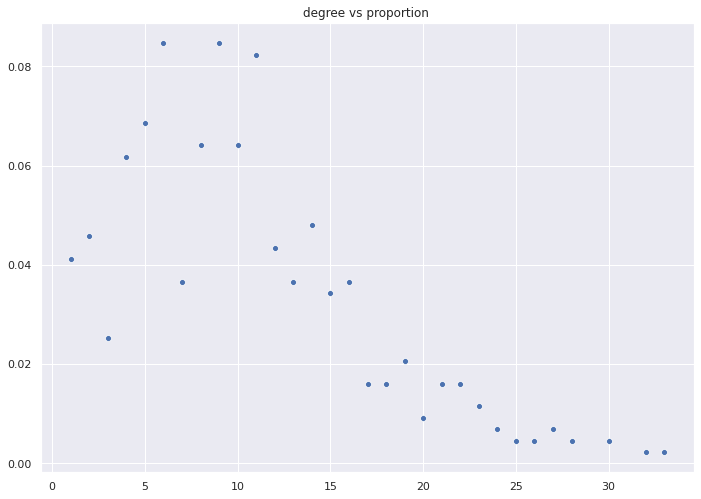

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(u, fd)
plt.title("degree vs proportion ")
#plt.xlabel("Useregree")

Text(0.5, 0, 'Customer Degree')

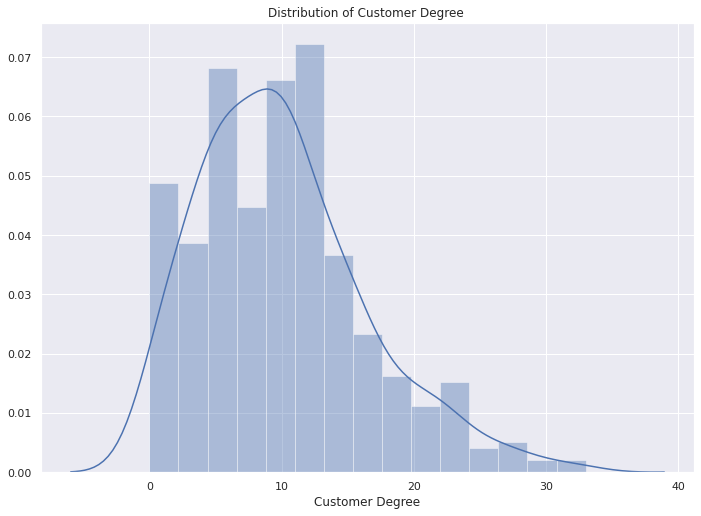

In [19]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(dc, hist = True)
plt.title("Distribution of Customer Degree ")
plt.xlabel("Customer Degree")

Text(0.5, 0, 'Item Degree')

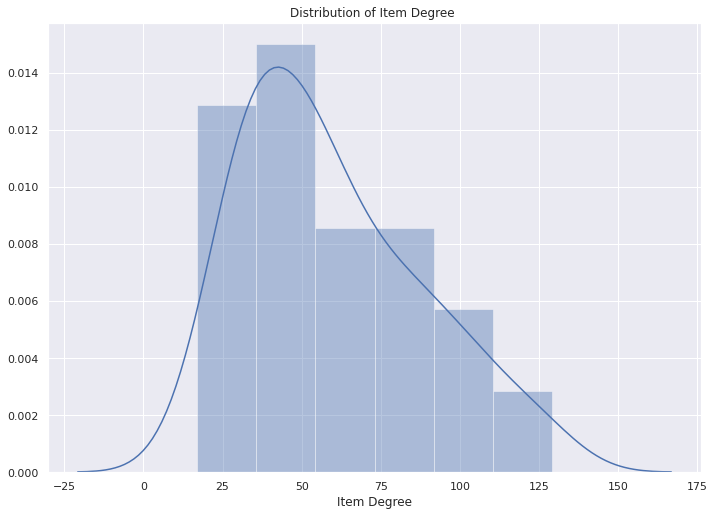

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(di, hist = True)
plt.title("Distribution of Item Degree ")
plt.xlabel("Item Degree")


Text(0.5, 0, 'Item Degree')

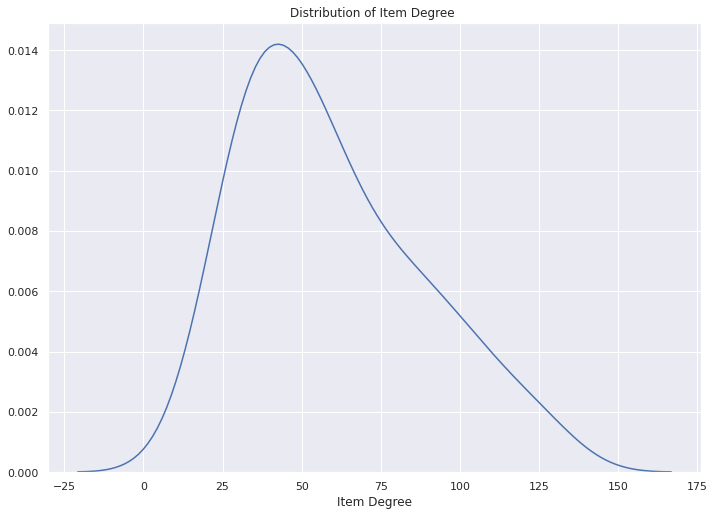

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(di, hist = False)
plt.title("Distribution of Item Degree ")
plt.xlabel("Item Degree")

In [22]:
dc= bipartite.degree_centrality(B, cust_nodes)
sdcc = {}
sdci = {}
for k, v in sorted(dc.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Customers"):
        sdcc[k] = v
    else:
        sdci[k] = v

del dc

In [23]:
list(sdcc.keys())[:10]

['Customers/14456',
 'Customers/17920',
 'Customers/16549',
 'Customers/16931',
 'Customers/17238',
 'Customers/15547',
 'Customers/18118',
 'Customers/14546',
 'Customers/16686',
 'Customers/16713']

In [24]:
list(sdci.keys())[:10]

['Items/20728',
 'Items/22720',
 'Items/23298',
 'Items/22457',
 'Items/84879',
 'Items/21754',
 'Items/23202',
 'Items/23207',
 'Items/23322',
 'Items/22961']

In [25]:

cr = bipartite.clustering(B)
cc = {}
ci = {}
for k, v in sorted(cr.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Customers"):
        cc[k] = v
    else:
        ci[k] = v

del cr

Text(0.5, 0, 'Customer Clustering Coefficients')

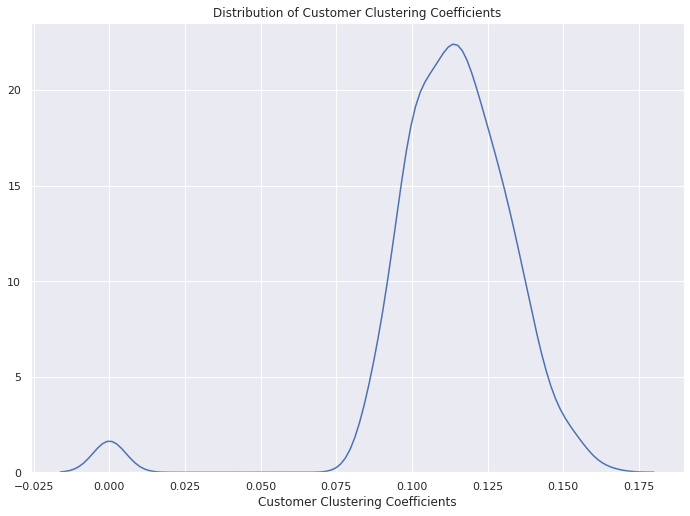

In [26]:
npvals = np.fromiter(cc.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Customer Clustering Coefficients")
plt.xlabel("Customer Clustering Coefficients")

Text(0.5, 0, 'Item Clustering Coefficients')

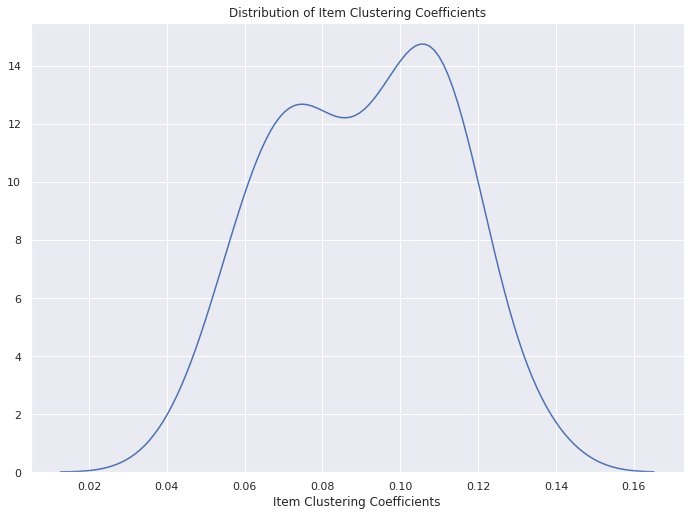

In [27]:
npvals = np.fromiter(ci.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Item Clustering Coefficients")
plt.xlabel("Item Clustering Coefficients")

In [36]:
cust_graph = nx.bipartite.projected_graph(B, cust_nodes)
item_graph = nx.bipartite.projected_graph(B, item_nodes)

In [40]:
nx.is_connected(cust_graph)

False

In [37]:
[len(c) for c in sorted(nx.connected_components(cust_graph), key=len, reverse=True)]

[437, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [38]:
[len(c) for c in sorted(nx.connected_components(item_graph), key=len, reverse=True)]

[75]

In [39]:
nx.is_connected(item_graph)

True